# 양방향 LSTM 감성 분류기

이 노트북에서 *양방향* LSTM을 만들어 감성에 따라 IMDB 영화 리뷰를 분류합니다.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rickiepark/dl-illustrated/blob/master/notebooks/11-6.bi_lstm_sentiment_classifier.ipynb)

#### 라이브러리 적재

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

#### 하이퍼파라미터 설정

In [2]:
# 출력 디렉토리
output_dir = 'model_output/biLSTM'

# 훈련
epochs = 6
batch_size = 128

# 벡터 공간 임베딩
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 # 두베!
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM 층 구조
n_lstm = 256 
drop_lstm = 0.2

#### 데이터 적재

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # n_words_to_skip 삭제

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

#### 데이터 전처리

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### 신경망 만들기

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [6]:
# 양 방향으로 가중치가 있기 때문에 LSTM 층 파라미터가 두 배가 됩니다.
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               657408    
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 1,297,921
Trainable params: 1,297,921
Non-trainable params: 0
_________________________________________________________________


#### 모델 설정

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 훈련!

In [9]:
# 데이터셋이 작기 때문에 긴 문장에 걸쳐 단어의 복잡한 상호작용이 잘 학습되지 않습니다.
# CNN은 리뷰의 감성을 예측하는 위치에 상관없는 2개에서 4개까지 단어 조각을 선택합니다.
# 이 작업이 더 간단하기 때문에 데이터에서 학습하기 쉽습니다.
# 따라서 CNN이 IMDB 데이터셋에서 성능이 더 좋습니다.
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/6
196/196 [==============================] - 25s 84ms/step - loss: 0.6537 - accuracy: 0.6048 - val_loss: 0.3633 - val_accuracy: 0.8423
Epoch 2/6
196/196 [==============================] - 16s 80ms/step - loss: 0.3209 - accuracy: 0.8698 - val_loss: 0.3295 - val_accuracy: 0.8663
Epoch 3/6
196/196 [==============================] - 16s 81ms/step - loss: 0.2175 - accuracy: 0.9188 - val_loss: 0.3238 - val_accuracy: 0.8674
Epoch 4/6
196/196 [==============================] - 16s 81ms/step - loss: 0.1764 - accuracy: 0.9362 - val_loss: 0.3406 - val_accuracy: 0.8714
Epoch 5/6
196/196 [==============================] - 16s 82ms/step - loss: 0.1392 - accuracy: 0.9492 - val_loss: 0.3772 - val_accuracy: 0.8633
Epoch 6/6
196/196 [==============================] - 16s 82ms/step - loss: 0.1126 - accuracy: 0.9603 - val_loss: 0.3652 - val_accuracy: 0.8640


#### 평가

In [10]:
model.load_weights(output_dir+"/weights.04.hdf5") 

In [11]:
y_hat = model.predict(x_valid)

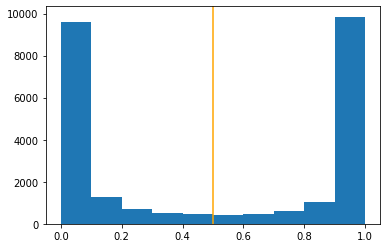

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'94.22'